In [32]:
from custom_gates import *
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from itertools import cycle
from weylchamber import c1c2c3
from qiskit.circuit.library.standard_gates import *
from qiskit.quantum_info import Operator, random_unitary, random_clifford
import scipy.optimize as opt
import hashlib


In [33]:
import matplotlib.pyplot as plt
# plt.style.use(["science", "ieee"])
# plt.plot([0,0], [1,1]);
# plt.style.use(["science", "ieee"])
#I'm not sure why but the styles don't get updated until after running twice, so monkey fix like this??

In [34]:
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)


In [35]:
import h5py

def h5py_load(filekey, *args):
    filename = f"data/{filekey}.h5"
    results = {}
    try:
        with h5py.File(filename, "r") as h5f:
            for arg in args:
                results[arg] = h5f[arg][:]
        return results
    except FileNotFoundError:
        logging.debug(f"Failed to load {filename}")
        return None


def h5py_save(filekey, **kwargs):
    filename = f"data/{filekey}.h5"
    with h5py.File(filename, "a") as h5f:
        for key, value in kwargs.items():
            try:
                del h5f[key]
            except Exception:
                pass
            h5f.create_dataset(key, data=value)
    logging.debug(f"Successfully saved to {filename}")


# we need some helper method to fix ragged arrays from training loss data
# previously, I was padding values with -1, so data points could easily be deleted later,
# I think it makes more sense to pad with the last remaining value, since training converges it just sits at that value
#TODO: could rewrite for so functional handles deepcopying rather than caller like as is currently
def rag_to_pad(arr):
    max_len = max(len(arr[i]) for i in range(len(arr)))
    for i in range(len(arr)):
        temp_len = len(arr[i])
        for j in range(max_len):
            if j >= temp_len:
                if j == 0:
                    raise ValueError("cant extend blank row")
                arr[i].append(arr[i][j-1])
                #arr[i].append(-1)
    return np.array(arr)

#rewrite convert to ragged array by detecting when row is being extended
def pad_to_rag(arr):
    arr = arr.tolist()
    for i in range(len(arr)):
        for j in range(len(arr[i])):
            #if arr[i][j] == -1:
            if arr[i][j] == arr[i][j-1]:
                arr[i] = arr[i][0:j]
                break
    return arr

#test
# arr = [[1, 2, 3, 4], [1, 2], [1, 2, 3]]
# arr = rag_to_pad(arr)
# print(arr)
# arr = pad_to_rag(arr)
# print(arr)

In [36]:
class TemplateCircuit:
    def __init__(
        self,
        n_qubits=2,
        base_gate_class=RiSwapGate,
        gate_2q_params=[1 / 2],
        edge_params=[(0, 1)],
        trotter=False,
    ):
        """Initalizes a qiskit.quantumCircuit object with unbound 1Q gate parameters
        Args:
            n_qubits: size of target unitary,
            base_gate_class: Gate class of 2Q gate,
            gate_2q_params: List of params to define template gate cycle sequence
            edge_params: List of edges to define topology cycle sequence
            trotter: if true, only use gate_2q_params[0], override cycle length and edge_params, each 1Q gate share parameters per qubit row
        """
        self.hash = (
            str(n_qubits)
            + str(base_gate_class)
            + str(gate_2q_params)
            + str(edge_params)
            + str(trotter)
        )

        if n_qubits != 2 and trotter:
            raise NotImplementedError
        self.n_qubits = n_qubits
        self.trotter = trotter
        self.circuit = QuantumCircuit(n_qubits)
        self.gate_2q_base = base_gate_class

        self.cycles = 0

        if self.trotter:
            if self.gate_2q_base != RiSwapGate:
                raise NotImplementedError
            # fixed param value, take first element
            self.gate_2q_params = cycle(gate_2q_params[:1])
            # override edges
            self.gate_2q_edges = cycle([(0, 1)])
            # fixed length, equals a full gate
            self.cycle_length = 1
        else:
            self.gate_2q_params = cycle(gate_2q_params)
            self.gate_2q_edges = cycle(edge_params)
            self.cycle_length = max(len(gate_2q_params), len(edge_params))

        self.gen_1q_params = self._param_iter()

    # def __str__(self):
    #     s = ""
    #     for param in self.gate_2q_params:
    #         s += self.gate_2q_base.latex_string(param)
    #     return s

    def build(self, n_repetitions):
        self._reset()
        if self.trotter:
            n_repetitions = int(1 / next(self.gate_2q_params))
        for _ in range(n_repetitions - 1):
            self._build_cycle()

    def _reset(self):
        """Return template to a single cycle"""
        self.cycles = 0
        self.circuit = QuantumCircuit(self.n_qubits)
        self._build_cycle(initial=True)

    def initial_guess(self):
        """returns a np array of random values for each parameter"""
        return np.random.random(len(self.circuit.parameters)) * 2 * np.pi

    def eval(self, Xk):
        """returns an Operator after binding parameter array to template"""
        return Operator(
            self.circuit.assign_parameters(
                {parameter: i for parameter, i in zip(self.circuit.parameters, Xk)}
            )
        ).data

    def _param_iter(self):
        index = 0
        while True:
            # Check if Parameter already created, then return reference to that variable
            def _filter_param(param):
                return param.name == f"P{index}"

            res = list(filter(_filter_param, self.circuit.parameters))
            if len(res) == 0:
                yield Parameter(f"P{index}")
            else:
                yield res[0]
            index += 1
            if self.trotter:
                index %= 3 * self.n_qubits

    def _build_cycle(self, initial=False):
        """Extends tempalte by one full cycle"""
        if initial:
            # before build by extend, add first pair of 1Qs
            for qubit in range(self.n_qubits):
                self.circuit.u(*[next(self.gen_1q_params) for _ in range(3)], qubit)
        for _ in range(self.cycle_length):
            edge = next(self.gate_2q_edges)
            self.circuit.append(self.gate_2q_base(next(self.gate_2q_params)), edge)
            for qubit in edge:
                self.circuit.u(*[next(self.gen_1q_params) for _ in range(3)], qubit)
        self.cycles += 1


In [37]:
# a = TemplateCircuit(
#     gate_2q_params=[1 /3, 1 / 3], n_qubits=2, edge_params=[(0, 1), (0, 2), (1, 2)], trotter=True
# )
# a.build(2)
# a.circuit.draw(output="mpl")


In [38]:
class TemplateOptimizer:
    def __init__(
        self,
        template,
        objective_function_name="basic",
        unitary_sample_function="Haar",
        n_samples=1,
        template_iter_range=range(2, 4),
    ):
        """Args:
        template: TemplateCircuit object
        objective_function_name: "nuop|basic" or "weyl"
        unitary_sample_function: "Haar" or "Clifford for random sampling, "SWAP", "CNOT", "iSWAP" for single gates
        n_samples: the number of times to sample a gate and minimize template on
        template_iter_range: a range() object that whos values are passed to template.build()
        """
        self.template = template
        self.sampler = self._sample_function(unitary_sample_function)
        self.n_samples = n_samples
        self.obj_f_name = objective_function_name
        self.template_iter_range = template_iter_range
        self.filekey = hashlib.sha1(
            (
                self.template.hash
                + str(objective_function_name)
                + str(unitary_sample_function)
                + str(template_iter_range)
            ).encode()
        ).hexdigest()
        self.plot_title = None
        self.training_loss = []
        self.training_reps = []

    def run(self, override_saved=False):
        # first attempt to load n_samples from data
        offset = 0
        results = None
        if not override_saved:
            results = h5py_load(self.filekey, "training_loss", "training_reps")
            if results is not None:
                self.training_loss = pad_to_rag(results["training_loss"])
                self.training_reps = results["training_reps"].tolist()
                offset = len(self.training_loss)
                logging.info(f"Loaded {offset} samples")

        # run minimize on the remaining samples
        # use try finally, so if end early stills writes back what it has thus far
        # XXX I'm not sure this actually works, dont rely on it
        try:
            for i in range(offset, self.n_samples):
                logging.info(f"Starting sample iter {i}")
                self.training_loss.append([])
                target_unitary = self.sampler()
                obj = self._objective_function(self.obj_f_name, target_unitary)
                self.minimize(obj=obj, iter=i, t_range=self.template_iter_range)
        finally:
            # finally, save again
            if self.n_samples > offset:
                # use list comprehension to pass by value (deepcopy)
                h5py_save(
                    self.filekey,
                    training_loss=rag_to_pad([row[:] for row in self.training_loss]),
                    training_reps=self.training_reps,
                )

    def minimize(self, obj, iter, t_range):
        # NOTE: potential for speedup?
        # you can calculate ahead of time the number of repetitions needed using traces??

        # callback used to save current loss after each iteration
        def callbackF(xk):
            loss = obj(xk)
            temp_training_loss.append(loss)

        best_result = None
        best_Xk = None
        best_cycles = -1

        # each t creates fresh template with new repetition param
        for t in t_range:
            logging.info(f"Starting cycle length {t}")
            temp_training_loss = []
            self.template.build(n_repetitions=t)

            result = opt.minimize(
                fun=obj,
                x0=self.template.initial_guess(),
                callback=callbackF,
                options={"maxiter": 200},
            )

            # result is good, update temp vars
            if best_result is None or result.fun < best_result:
                best_result = result.fun
                best_Xk = result.x
                best_cycles = self.template.cycles
                self.training_loss[iter] = temp_training_loss

            # already good enough, save time by stopping here
            if best_result < 1e-9:
                logging.info(f"Break on cycle {t}")
                break

        logging.info(f"loss= {best_result}")
        self.training_reps.append(best_cycles)
        return best_result, best_Xk

    def _sample_function(self, name):
        if name == "CParitySwap":
            return lambda: CParitySwap()
        if name == "CiSWAP":
            return lambda: np.array(
                [
                    [1, 0, 0, 0, 0, 0, 0, 0],
                    [0, 1, 0, 0, 0, 0, 0, 0],
                    [0, 0, 1, 0, 0, 0, 0, 0],
                    [0, 0, 0, 1, 0, 0, 0, 0],
                    [0, 0, 0, 0, 1, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 1j, 0],
                    [0, 0, 0, 0, 0, 1j, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 1],
                ]
            )
        if name == "CCiX":
            return lambda: np.array(
                [
                    [1, 0, 0, 0, 0, 0, 0, 0],
                    [0, 1, 0, 0, 0, 0, 0, 0],
                    [0, 0, 1, 0, 0, 0, 0, 0],
                    [0, 0, 0, 1, 0, 0, 0, 0],
                    [0, 0, 0, 0, 1, 0, 0, 0],
                    [0, 0, 0, 0, 0, 1, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 1j],
                    [0, 0, 0, 0, 0, 0, 1j, 0],
                ]
            )
        if name == "Peres":
            return lambda: np.array(
                [
                    [1, 0, 0, 0, 0, 0, 0, 0],
                    [0, 1, 0, 0, 0, 0, 0, 0],
                    [0, 0, 1, 0, 0, 0, 0, 0],
                    [0, 0, 0, 1, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 1],
                    [0, 0, 0, 0, 0, 0, 1, 0],
                    [0, 0, 0, 0, 0, 1, 0, 0],
                    [0, 0, 0, 0, 1, 0, 0, 0],
                ]
            )
        if name == "Toffoli":
            return lambda: CCXGate()
        if name == "CSWAP":
            return lambda: CSwapGate()
        if name == "RCCXGate":
            return lambda: RCCXGate()
        if name == "SWAP":
            return lambda: SwapGate()
        if name == "CNOT":
            return lambda: CXGate()
        if name == "iSWAP":
            return lambda: iSwapGate()
        if name == "Haar":
            return lambda: random_unitary(dims=2 ** self.template.n_qubits).data
        if name == "Clifford":
            return lambda: Operator(
                random_clifford(num_qubits=self.template.n_qubits)
            ).data
        else:
            raise ValueError(f"No sample function named {name}")

    def _objective_function(self, name, target):
        if name == "basic":
            return (
                lambda X: 1
                - np.abs(
                    np.trace(np.matmul(np.matrix(target).getH(), self.template.eval(X)))
                )
                / np.array(target).shape[0]
            )
        if name == "nuop":
            return lambda X: 1 - np.abs(
                np.sum(np.multiply(self.template.eval(X), np.conj(target)))
            ) / (2 * self.template.n_qubits)
        if name == "weyl":
            if self.template.n_qubits != 2:
                raise ValueError("Weyl chamber only for 2Q gates")
            return lambda X: np.linalg.norm(
                np.array(c1c2c3(target)) - np.array(c1c2c3(self.template.eval(X)))
            )
        else:
            raise ValueError(f"No objective function named {name}")

    @staticmethod
    def plot(fig_title, *optimizers):
        c = ["black", "tab:red", "tab:blue", "tab:orange", "tab:green"]

        # each optimizer is its own column subplot
        fig, axs = plt.subplots(1, len(optimizers), sharey=True, squeeze=False)
        for ax_index, optimizer in enumerate(optimizers):

            # each sample gets plotted as a faint line
            for i in range(optimizer.n_samples):
                axs[0][ax_index].plot(
                    optimizer.training_loss[i],
                    alpha=0.2,
                    color=c[optimizer.training_reps[i]%len(c)],
                    linestyle="-",
                )

            # plot horizontal line to show average of final converged value
            converged_averaged = np.mean([el[-1] for el in optimizer.training_loss])
            axs[0][ax_index].axhline(
                converged_averaged, alpha=0.8, color="tab:gray", linestyle="--"
            )
            axs[0][ax_index].text(
                0.5,
                converged_averaged * 1.01,
                "Avg: " + "{:.2E}".format(converged_averaged),
                {"size": 5},
            )

            # custom average for ragged array
            # XXX there must be a smart way to do this I couldn't think of it at the time I wrote this :(
            for reps in set(optimizer.training_reps):
                # filter training data for each rep value
                temp = [
                    optimizer.training_loss[i]
                    for i in range(len(optimizer.training_reps))
                    if optimizer.training_reps[i] == reps
                ]

                # construct average over points where data exists
                # uses row-col outer-inner loop over points, increments counter k for norming
                temp_average = []
                for i in range(max([len(el) for el in temp])):
                    temp_average.append(0)
                    k = 0
                    for j in range(len(temp)):
                        if i < len(temp[j]):
                            temp_average[i] += temp[j][i]
                            k += 1
                    temp_average[i] /= k

                # plot average with full color
                axs[0][ax_index].plot(
                    temp_average, color=c[reps%len(c)], label=f"L{reps}", linestyle="-"
                )

            axs[0][ax_index].set_yscale("log")
            axs[0][ax_index].set_xlabel("Training Steps")
            axs[0][ax_index].set_title(f"{optimizer.plot_title}")
            axs[0][ax_index].legend()

        fig.suptitle(f"{fig_title}, (N={optimizers[0].n_samples})", y=0.92)
        axs[0][0].set_ylabel("Training Loss")
        fig.tight_layout()
        fig.show()


# test objective function
# n = TemplateCircuit(n_qubits=3)
# a = TemplateOptimizer(n)._objective_function(name="nuop", target=Operator(CCXGate()).data)
# a(Operator(CCXGate()).data)


https://qutip.org/docs/latest/guide/guide-control.html#:~:text=The%20typical%20figure%20of%20merit%20for%20unitary%20systems%20is%20the%20normalised%20overlap%20of%20the%20evolution%20and%20the%20target.

INFO:root:Loaded 10 samples
INFO:root:Loaded 10 samples
C:\Users\hatlab-MSMT2\AppData\Local\Temp\ipykernel_12348\800765988.py:257: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


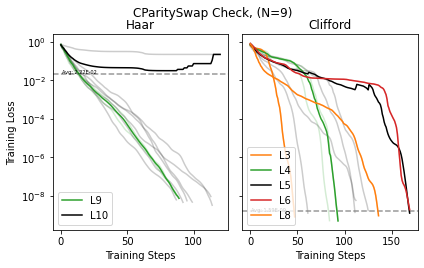

In [39]:
template = TemplateCircuit(n_qubits=3, base_gate_class=CParitySwap, gate_2q_params=[None], edge_params=[(0,1,2)])
optimizer4 = TemplateOptimizer(template, n_samples=9, unitary_sample_function="Haar", template_iter_range=range(1,11))
optimizer4.run()
optimizer4.plot_title = "Haar"

optimizer5 = TemplateOptimizer(template, n_samples=9, unitary_sample_function="Clifford", template_iter_range=range(1,11))
optimizer5.run()
optimizer5.plot_title = "Clifford"

TemplateOptimizer.plot(f"CParitySwap Check", optimizer4, optimizer5)

In [4]:
qc = QuantumCircuit(3)
qc.append(VSwap(), [0,1,2])
qc.draw(output='mpl')
print(VSwap().to_matrix())

[[ 1.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
   0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.78867513+0.j -0.21132487+0.j  0.        +0.j
   0.57735027+0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j -0.21132487+0.j  0.78867513+0.j  0.        +0.j
   0.57735027+0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.57735027+0.j
   0.        +0.j  0.57735027+0.j  0.57735027+0.j  0.        +0.j]
 [ 0.        +0.j -0.57735027+0.j -0.57735027+0.j  0.        +0.j
   0.57735027+0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j -0.57735027+0.j
   0.        +0.j  0.78867513+0.j -0.21132487+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j -0.57735027+0.j
   0.        +0.j -0.21132487+0.j  0.78867513+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
   

INFO:root:Loaded 3 samples
INFO:root:Starting sample iter 3
INFO:root:loss= 0.25000000158336066
INFO:root:Starting sample iter 4
INFO:root:loss= 4.3295256269004767e-10
INFO:root:Starting sample iter 5
INFO:root:loss= 0.3964466103670824
INFO:root:Starting sample iter 6
INFO:root:loss= 7.108258426313796e-10
INFO:root:Starting sample iter 7
INFO:root:loss= 0.2500000007828649
INFO:root:Starting sample iter 8
INFO:root:loss= 3.662088410294473e-10
INFO:root:Starting sample iter 9
INFO:root:loss= 4.031762701472985e-10


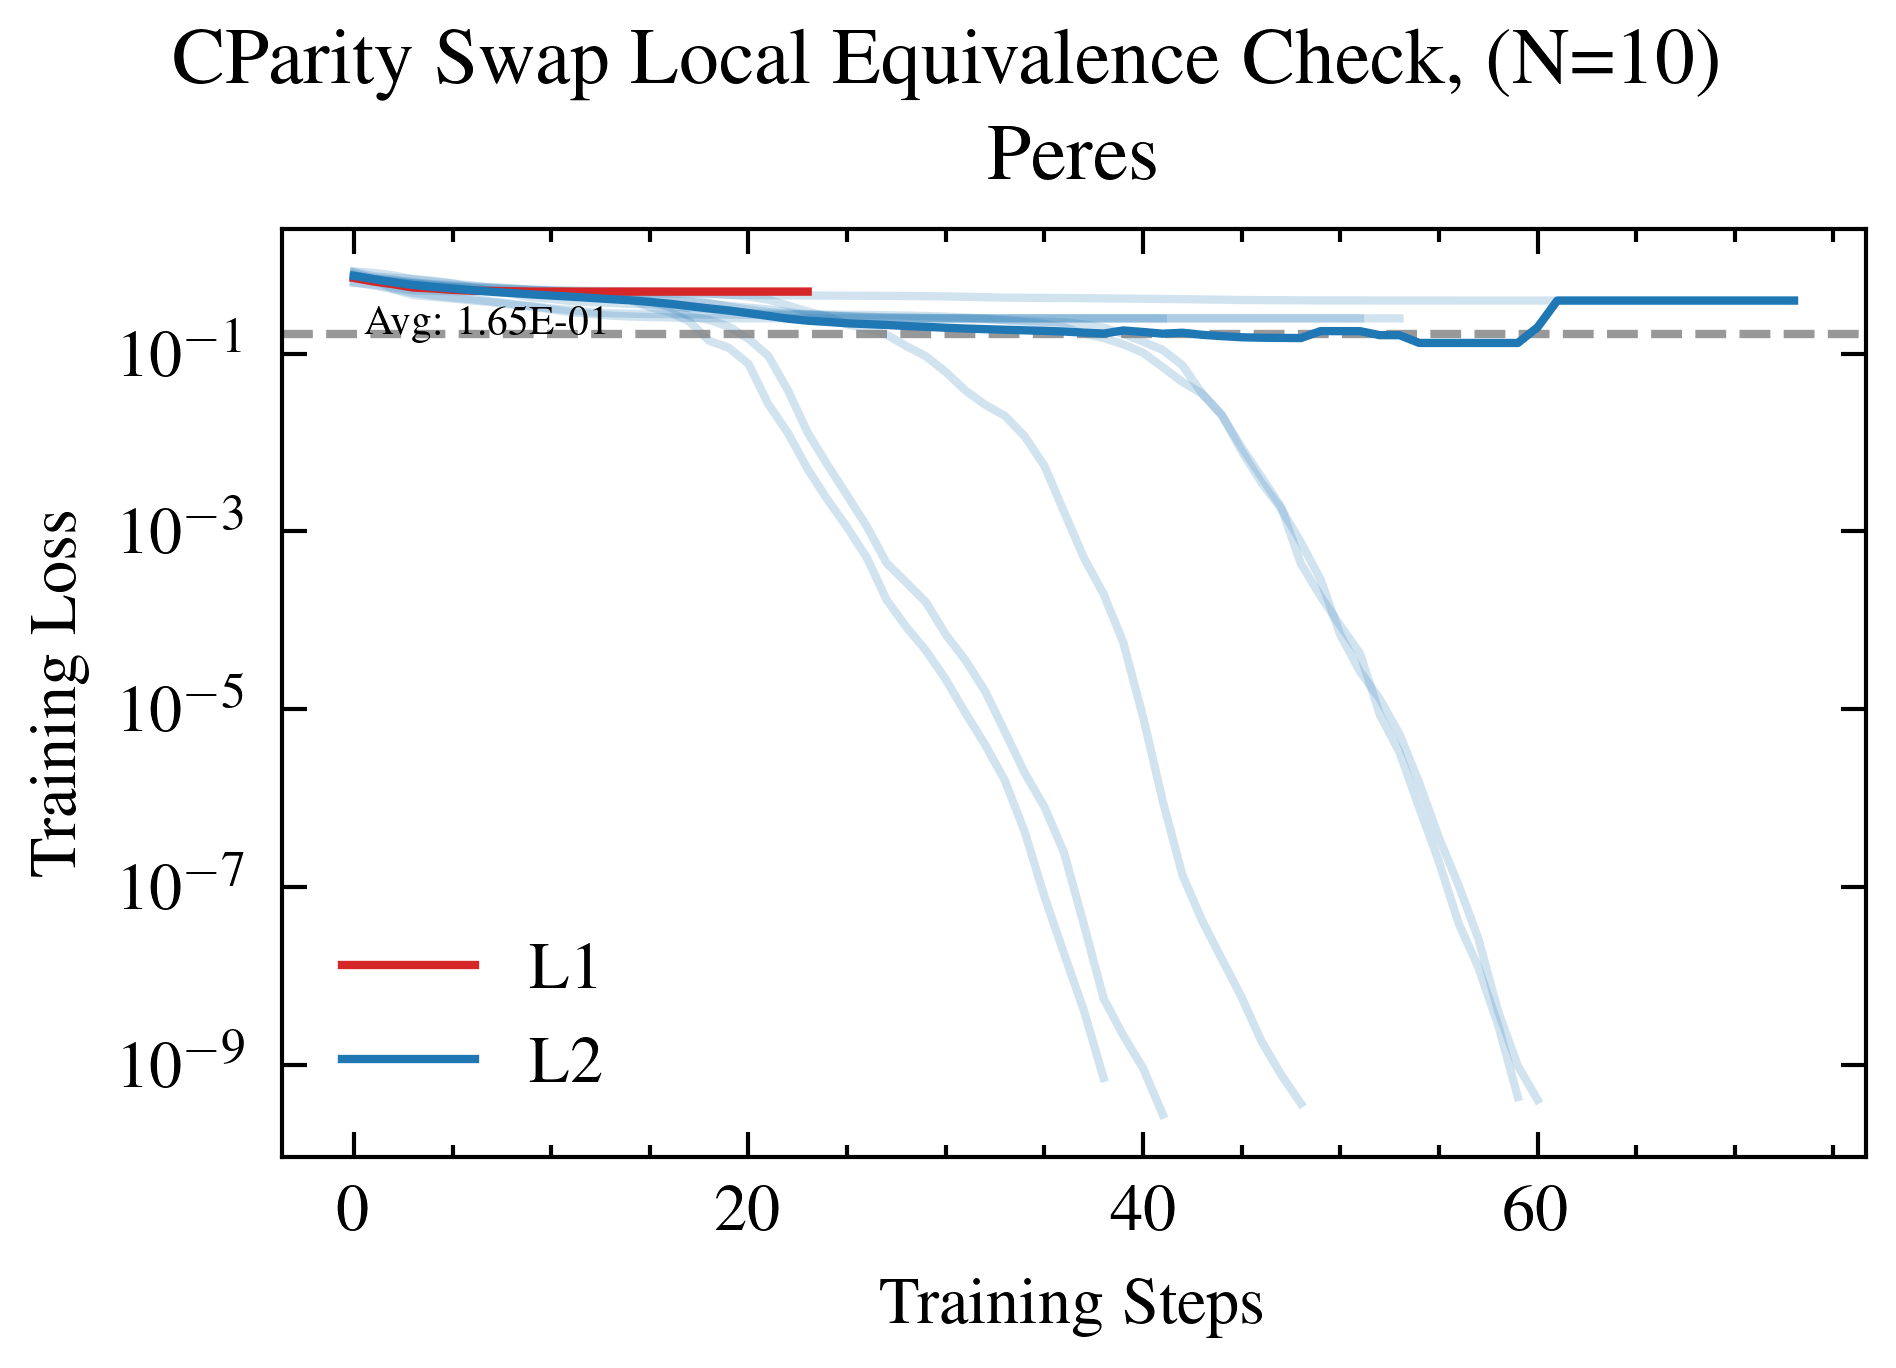

In [99]:
template = TemplateCircuit(n_qubits=3, base_gate_class=CParitySwap, gate_2q_params=[None],edge_params=[(0,1,2)])
optimizer4 = TemplateOptimizer(template, n_samples=10, unitary_sample_function="Peres", template_iter_range=range(1,3))
optimizer4.run()
optimizer4.plot_title = "Peres"

TemplateOptimizer.plot(f"CParitySwap Local Equivalence Check", optimizer4)

INFO:root:Loaded 3 samples
INFO:root:Starting sample iter 3
INFO:root:loss= 0.3610424225477816
INFO:root:Starting sample iter 4
INFO:root:loss= 0.3813373203081041
INFO:root:Starting sample iter 5
INFO:root:loss= 0.3875553788367371
INFO:root:Starting sample iter 6
INFO:root:loss= 0.3875553799024365
INFO:root:Starting sample iter 7
INFO:root:loss= 0.09955203725032868
INFO:root:Starting sample iter 8
INFO:root:loss= 0.36104242539115383
INFO:root:Starting sample iter 9
INFO:root:loss= 0.09955203725666861
INFO:root:Loaded 3 samples
INFO:root:Starting sample iter 3
INFO:root:loss= 0.250000001007766
INFO:root:Starting sample iter 4
INFO:root:loss= 0.25000000017886026
INFO:root:Starting sample iter 5
INFO:root:loss= 0.25000000166754355
INFO:root:Starting sample iter 6
INFO:root:loss= 0.25000000228593156
INFO:root:Starting sample iter 7
INFO:root:loss= 0.25000000022839475
INFO:root:Starting sample iter 8
INFO:root:loss= 0.25000000056147564
INFO:root:Starting sample iter 9
INFO:root:loss= 0.2500

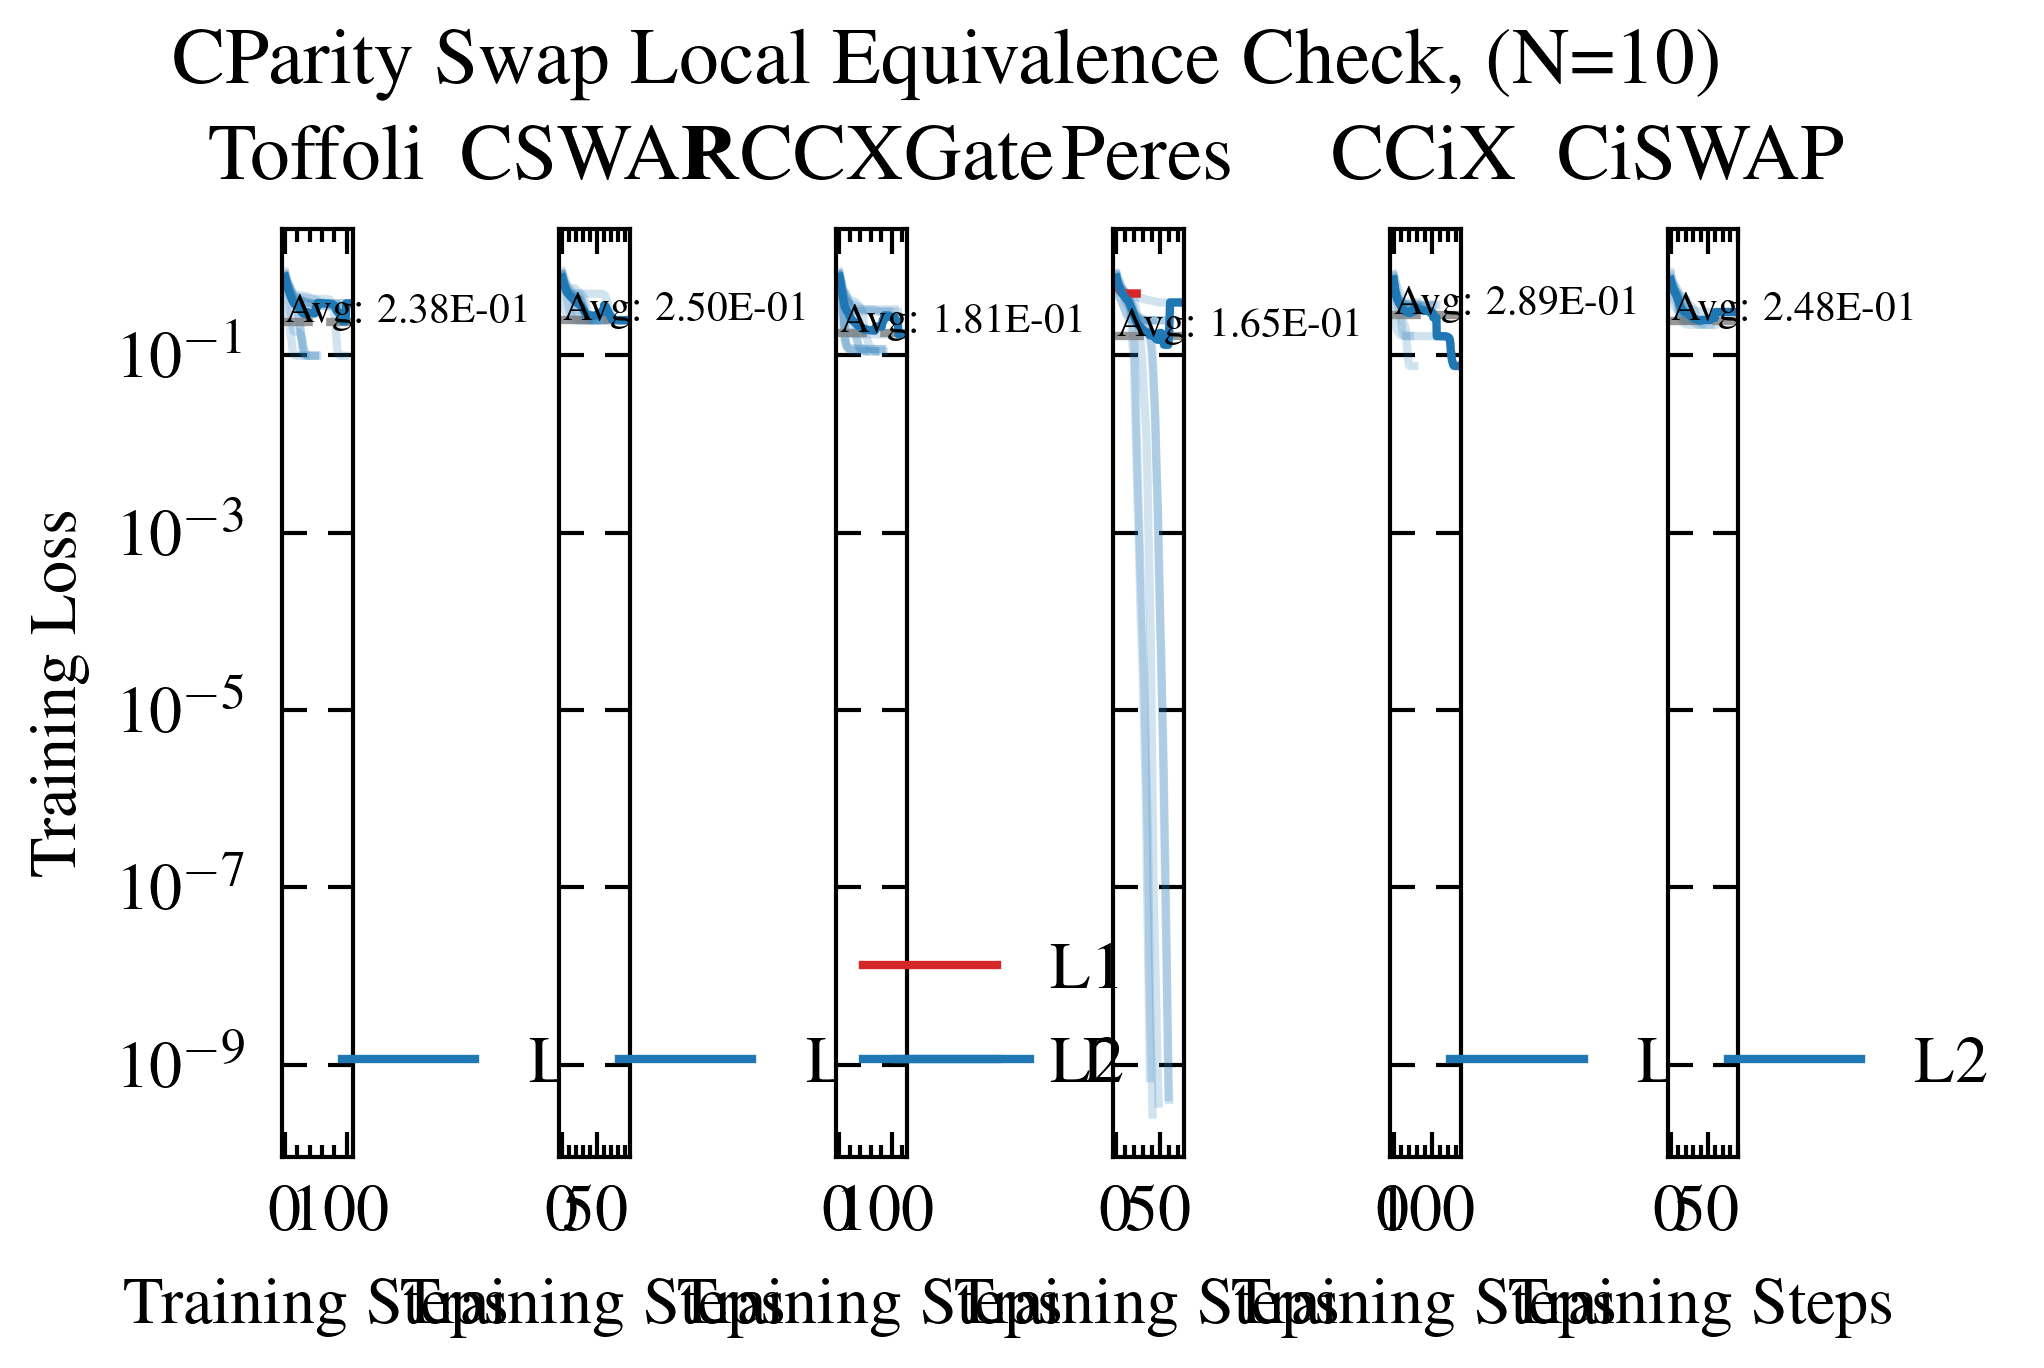

In [100]:
N=10
template = TemplateCircuit(n_qubits=3, base_gate_class=CParitySwap, gate_2q_params=[None],edge_params=[(0,1,2)])
optimizer = TemplateOptimizer(template, n_samples=N, unitary_sample_function="Toffoli", template_iter_range=range(1,3))
optimizer.run()
optimizer.plot_title = "Toffoli"

optimizer2 = TemplateOptimizer(template, n_samples=N, unitary_sample_function="CSWAP", template_iter_range=range(1,3))
optimizer2.run()
optimizer2.plot_title = "CSWAP"

optimizer3 = TemplateOptimizer(template, n_samples=N, unitary_sample_function="RCCXGate", template_iter_range=range(1,3))
optimizer3.run()
optimizer3.plot_title = "RCCXGate"

# optimizer4 = TemplateOptimizer(template, n_samples=3, unitary_sample_function="CCZ", template_iter_range=range(1,2))
# optimizer4.run()
# optimizer4.plot_title = "CCZ"
optimizer4 = TemplateOptimizer(template, n_samples=N, unitary_sample_function="Peres", template_iter_range=range(1,3))
optimizer4.run()
optimizer4.plot_title = "Peres"

optimizer5 = TemplateOptimizer(template, n_samples=N, unitary_sample_function="CCiX", template_iter_range=range(1,3))
optimizer5.run()
optimizer5.plot_title = "CCiX"

optimizer6 = TemplateOptimizer(template, n_samples=N, unitary_sample_function="CiSWAP", template_iter_range=range(1,3))
optimizer6.run()
optimizer6.plot_title = "CiSWAP"

TemplateOptimizer.plot(f"CParity Swap Local Equivalence Check", optimizer, optimizer2, optimizer3, optimizer4, optimizer5, optimizer6)

In [101]:
N=10
template = TemplateCircuit(n_qubits=3, base_gate_class=CParitySwap, gate_2q_params=[None],edge_params=[(0,1,2)])
optimizer = TemplateOptimizer(template, n_samples=N, unitary_sample_function="Toffoli", template_iter_range=range(1,4))
optimizer.run()
optimizer.plot_title = "Toffoli"

optimizer2 = TemplateOptimizer(template, n_samples=N, unitary_sample_function="CSWAP", template_iter_range=range(1,4))
optimizer2.run()
optimizer2.plot_title = "CSWAP"

optimizer3 = TemplateOptimizer(template, n_samples=N, unitary_sample_function="RCCXGate", template_iter_range=range(1,4))
optimizer3.run()
optimizer3.plot_title = "RCCXGate"

# optimizer4 = TemplateOptimizer(template, n_samples=3, unitary_sample_function="CCZ", template_iter_range=range(1,2))
# optimizer4.run()
# optimizer4.plot_title = "CCZ"
optimizer4 = TemplateOptimizer(template, n_samples=N, unitary_sample_function="Peres", template_iter_range=range(1,4))
optimizer4.run()
optimizer4.plot_title = "Peres"

optimizer5 = TemplateOptimizer(template, n_samples=N, unitary_sample_function="CCiX", template_iter_range=range(1,4))
optimizer5.run()
optimizer5.plot_title = "CCiX"

optimizer6 = TemplateOptimizer(template, n_samples=N, unitary_sample_function="CiSWAP", template_iter_range=range(1,4))
optimizer6.run()
optimizer6.plot_title = "CiSWAP"

TemplateOptimizer.plot(f"CParity Swap Local Equivalence Check", optimizer, optimizer2, optimizer3, optimizer4, optimizer5, optimizer6)

INFO:root:Starting sample iter 0


First, we do a test to show that for two known decompositions, iSwap takes 2 instances of SWAP takes 3 instances of $\sqrt[2]{iSwap}$ as expected. 
Noting that unfortunately, SWAP is much harder to find a solution for. I know that SWAP is the top vertex in the Weyl chamber, is this point hard to find because it is an isolated extrema? At first, I think it is counterintuitive that the template with more parameters (L=3) converges faster, but my guess is that because it has more degrees of freedom it is actually easier for it to find the solution more rapidly.

INFO:root:Loaded 5 samples
INFO:root:Loaded 5 samples


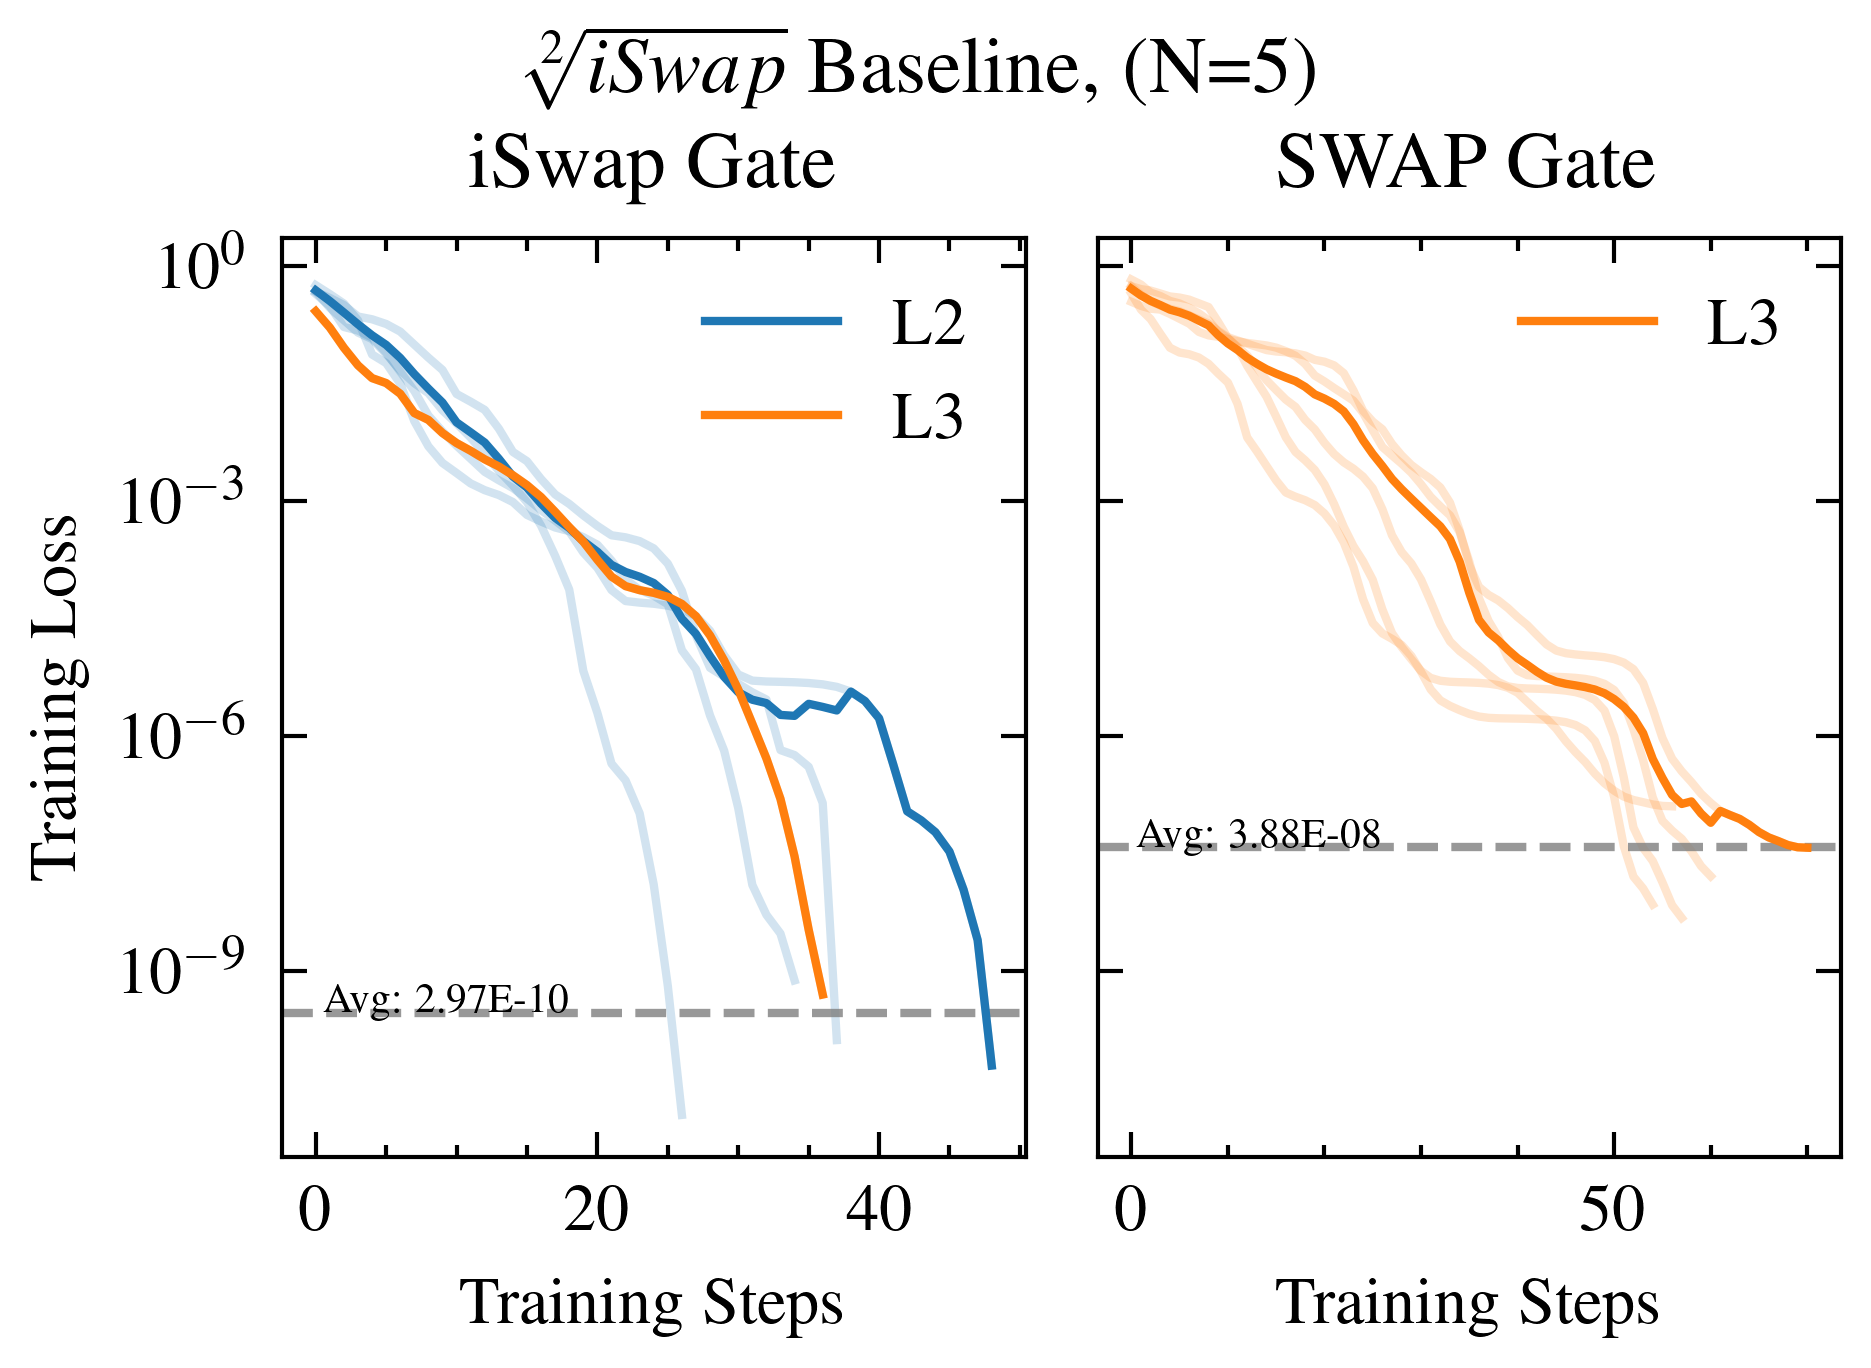

In [81]:
N = 5
template = TemplateCircuit()
optimizer = TemplateOptimizer(template, n_samples=N, unitary_sample_function="iSWAP")
optimizer.run(override_saved=False)
optimizer.plot_title = "iSwap Gate"
optimizer2 = TemplateOptimizer(template, n_samples=N, unitary_sample_function="SWAP")
optimizer2.run(override_saved=False)
optimizer2.plot_title = "SWAP Gate"
TemplateOptimizer.plot(f"{RiSwapGate.latex_string(2)} Baseline", optimizer, optimizer2)


Next, the experiment comparing Haar and Clifford sampling tells us if the unitaries which are more commonly found in CX constructed circuits (clifford) as easier or harder to build. This idea to compare these came from the iToffoli paper. It seems that both samplings converge to similar accuracy, but Haar unitaries are more likely to converge faster. Clifford has slightly better accuracy.

INFO:root:Loaded 5 samples
INFO:root:Loaded 15 samples


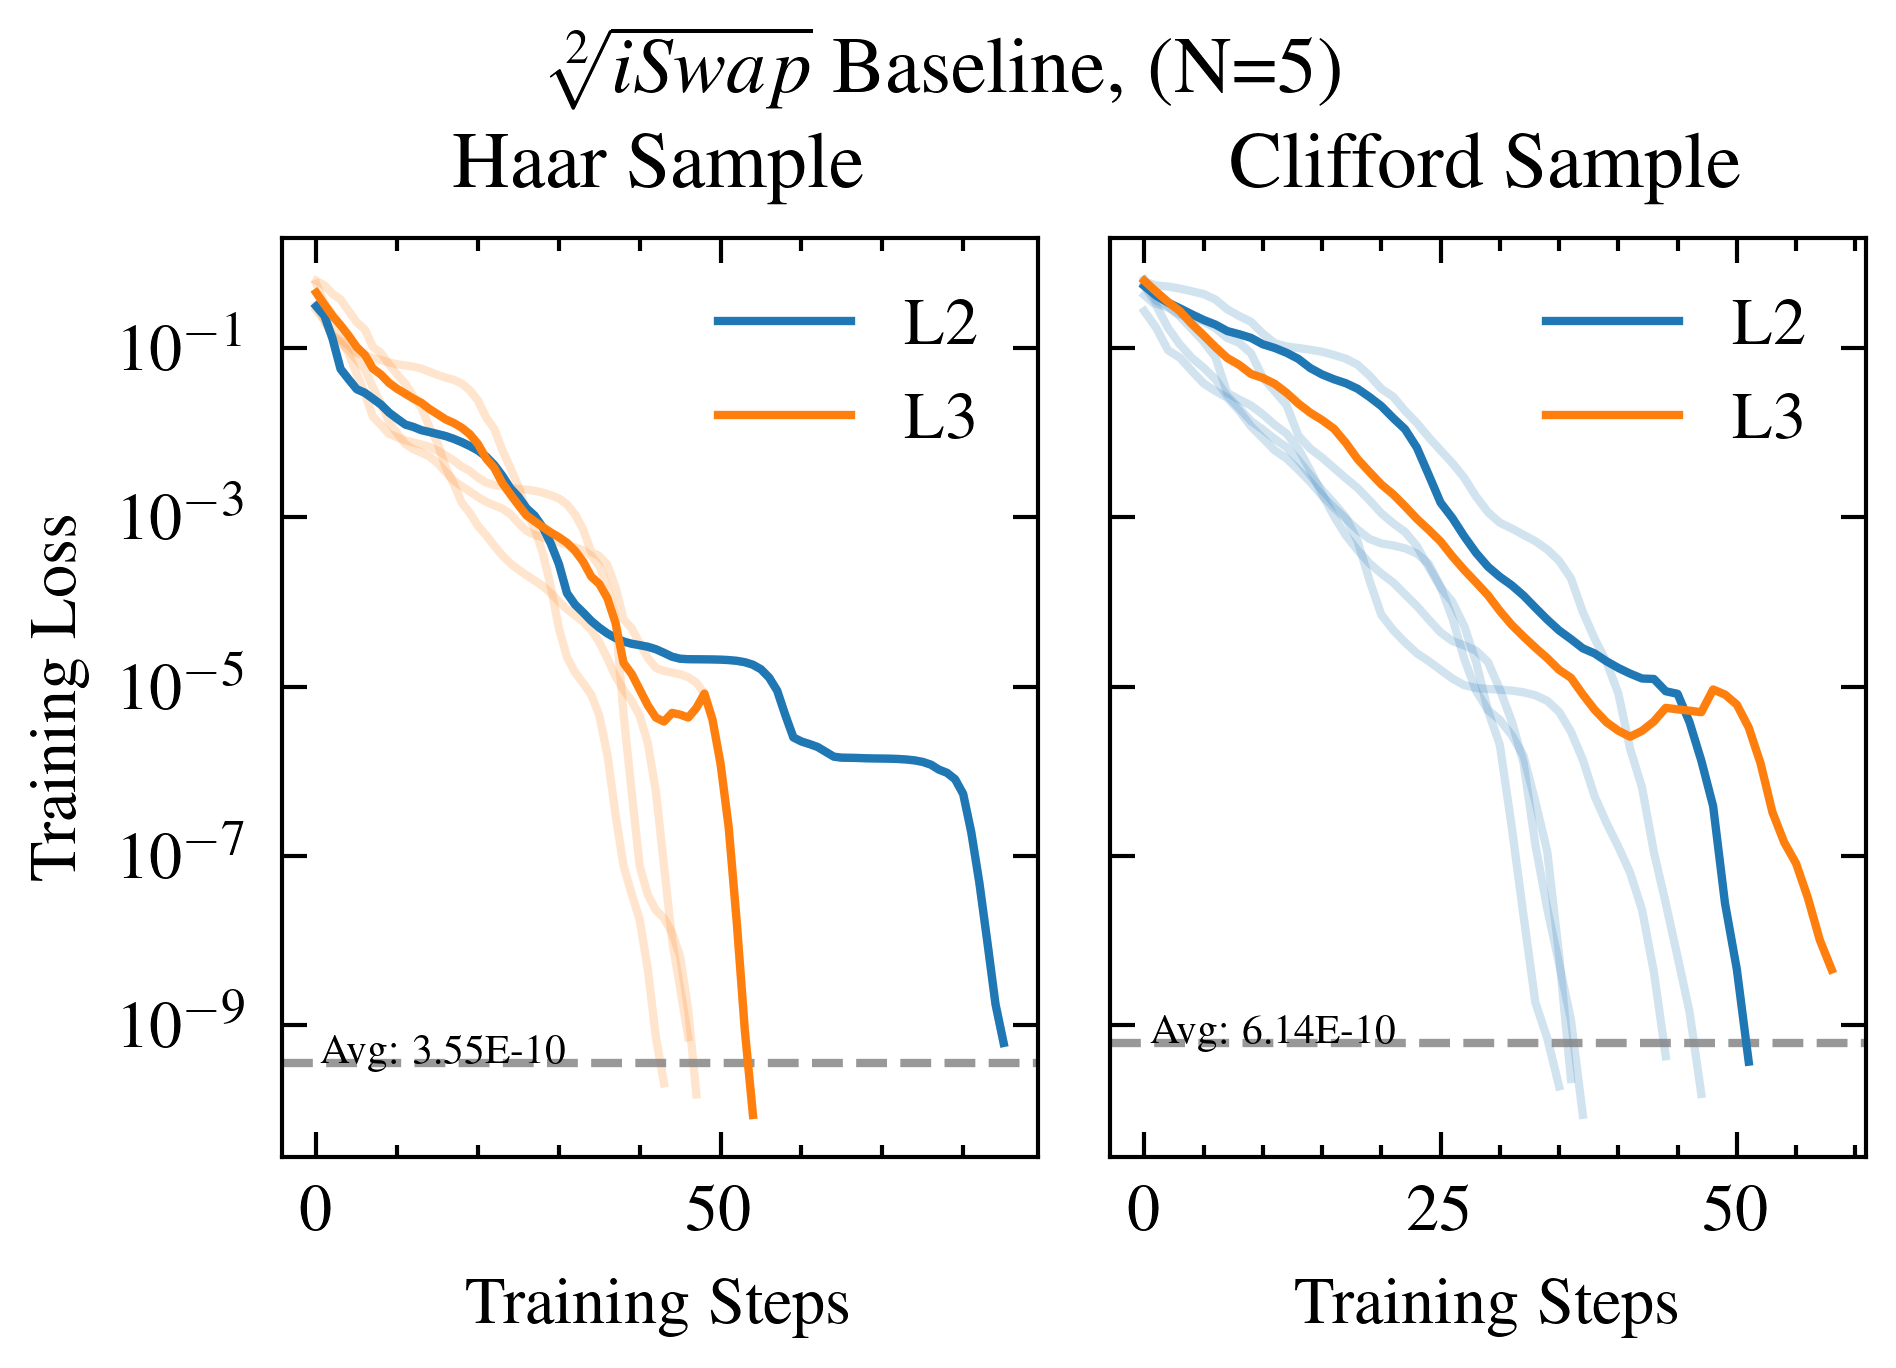

In [25]:
N = 5
template = TemplateCircuit()
optimizer = TemplateOptimizer(template, n_samples=N, unitary_sample_function="Haar")
optimizer.run()
optimizer.plot_title = "Haar Sample"
optimizer2 = TemplateOptimizer(
    template, n_samples=N, unitary_sample_function="Clifford"
)
optimizer2.run()
optimizer2.plot_title = "Clifford Sample"
TemplateOptimizer.plot(f"{RiSwapGate.latex_string(2)} Baseline", optimizer, optimizer2)


Next, we look at trotterization. These circuit templates have a fixed length because we want the $\sqrt[n]{iSwap}$ to build a full-length iSwap gate. From experimentation, I have found that if a gate takes 2 $\sqrt{iSwap}$ gates, it can be trotterized, since the gate is decomposable into a full-length proportional duration. If a gate takes 3 $\sqrt{iSwap}$ gates, SWAP for example, then smaller trotter steps never improves fidelity past ~.9, unfortunately seems to be an inaccessible decomposition using fixed repetitions. This can sort of be seen in these plots because there are sort of 2 distinct convergence values for each gate. However, also not that none of these decompositions are reaching good values, only of order $10^{-1}$.

INFO:root:Loaded 10 samples
INFO:root:Loaded 10 samples
INFO:root:Loaded 10 samples


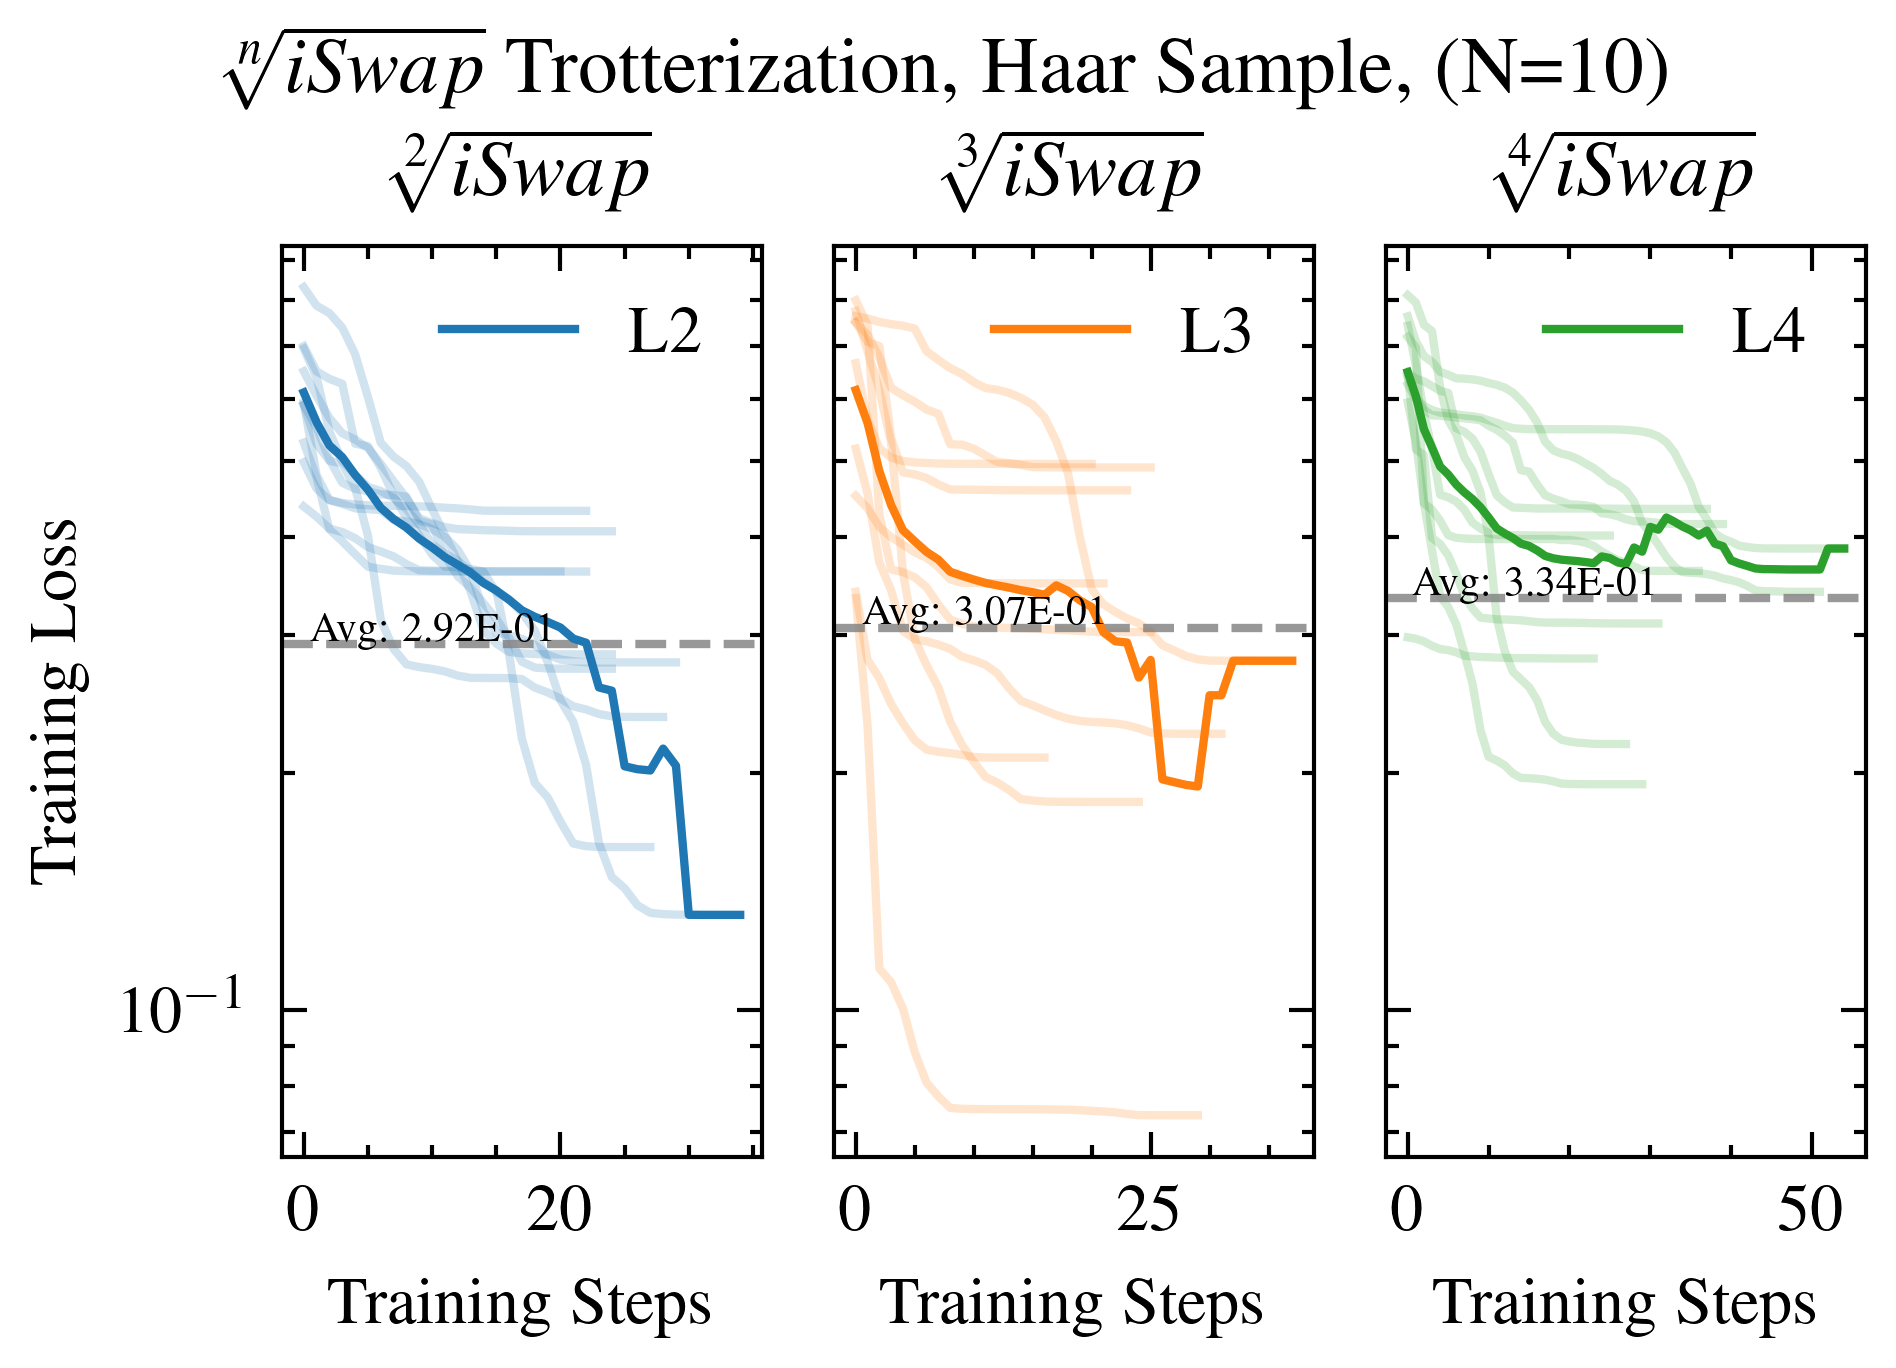

In [26]:
optimizer_list = []
N = 10
for x in range(2, 5):
    template = TemplateCircuit(trotter=True, gate_2q_params=[1 / x])
    # set max_iter=2 because rebuilding doesn't effect trotter template
    optimizer = TemplateOptimizer(
        template, n_samples=N, template_iter_range=range(1, 2)
    )
    optimizer.run(override_saved=False)
    optimizer.plot_title = RiSwapGate.latex_string(x)
    optimizer_list.append(optimizer)

TemplateOptimizer.plot(
    f"{RiSwapGate.latex_string()} Trotterization, Haar Sample", *optimizer_list
)


Next, we start looking at mixed bag templates, ie circuit templates that use a mix of $\sqrt[n]{iSwap}$ values. The intuition I had is that for the decomposition expressive power of $\sqrt{iSwap}$ may be more than needed for some target unitaries. By using a mixed bag, where n is diminishing, is as if using a smaller learning rate as converging to a solution (or like using a driver than an iron, then a putter.) What I suspect like before with trotterization is that there are 2 distinct points of convergence depending on whether the gate is accessible via 1 or 1.5 proportional iSwap durations.

INFO:root:Loaded 10 samples
INFO:root:Loaded 10 samples


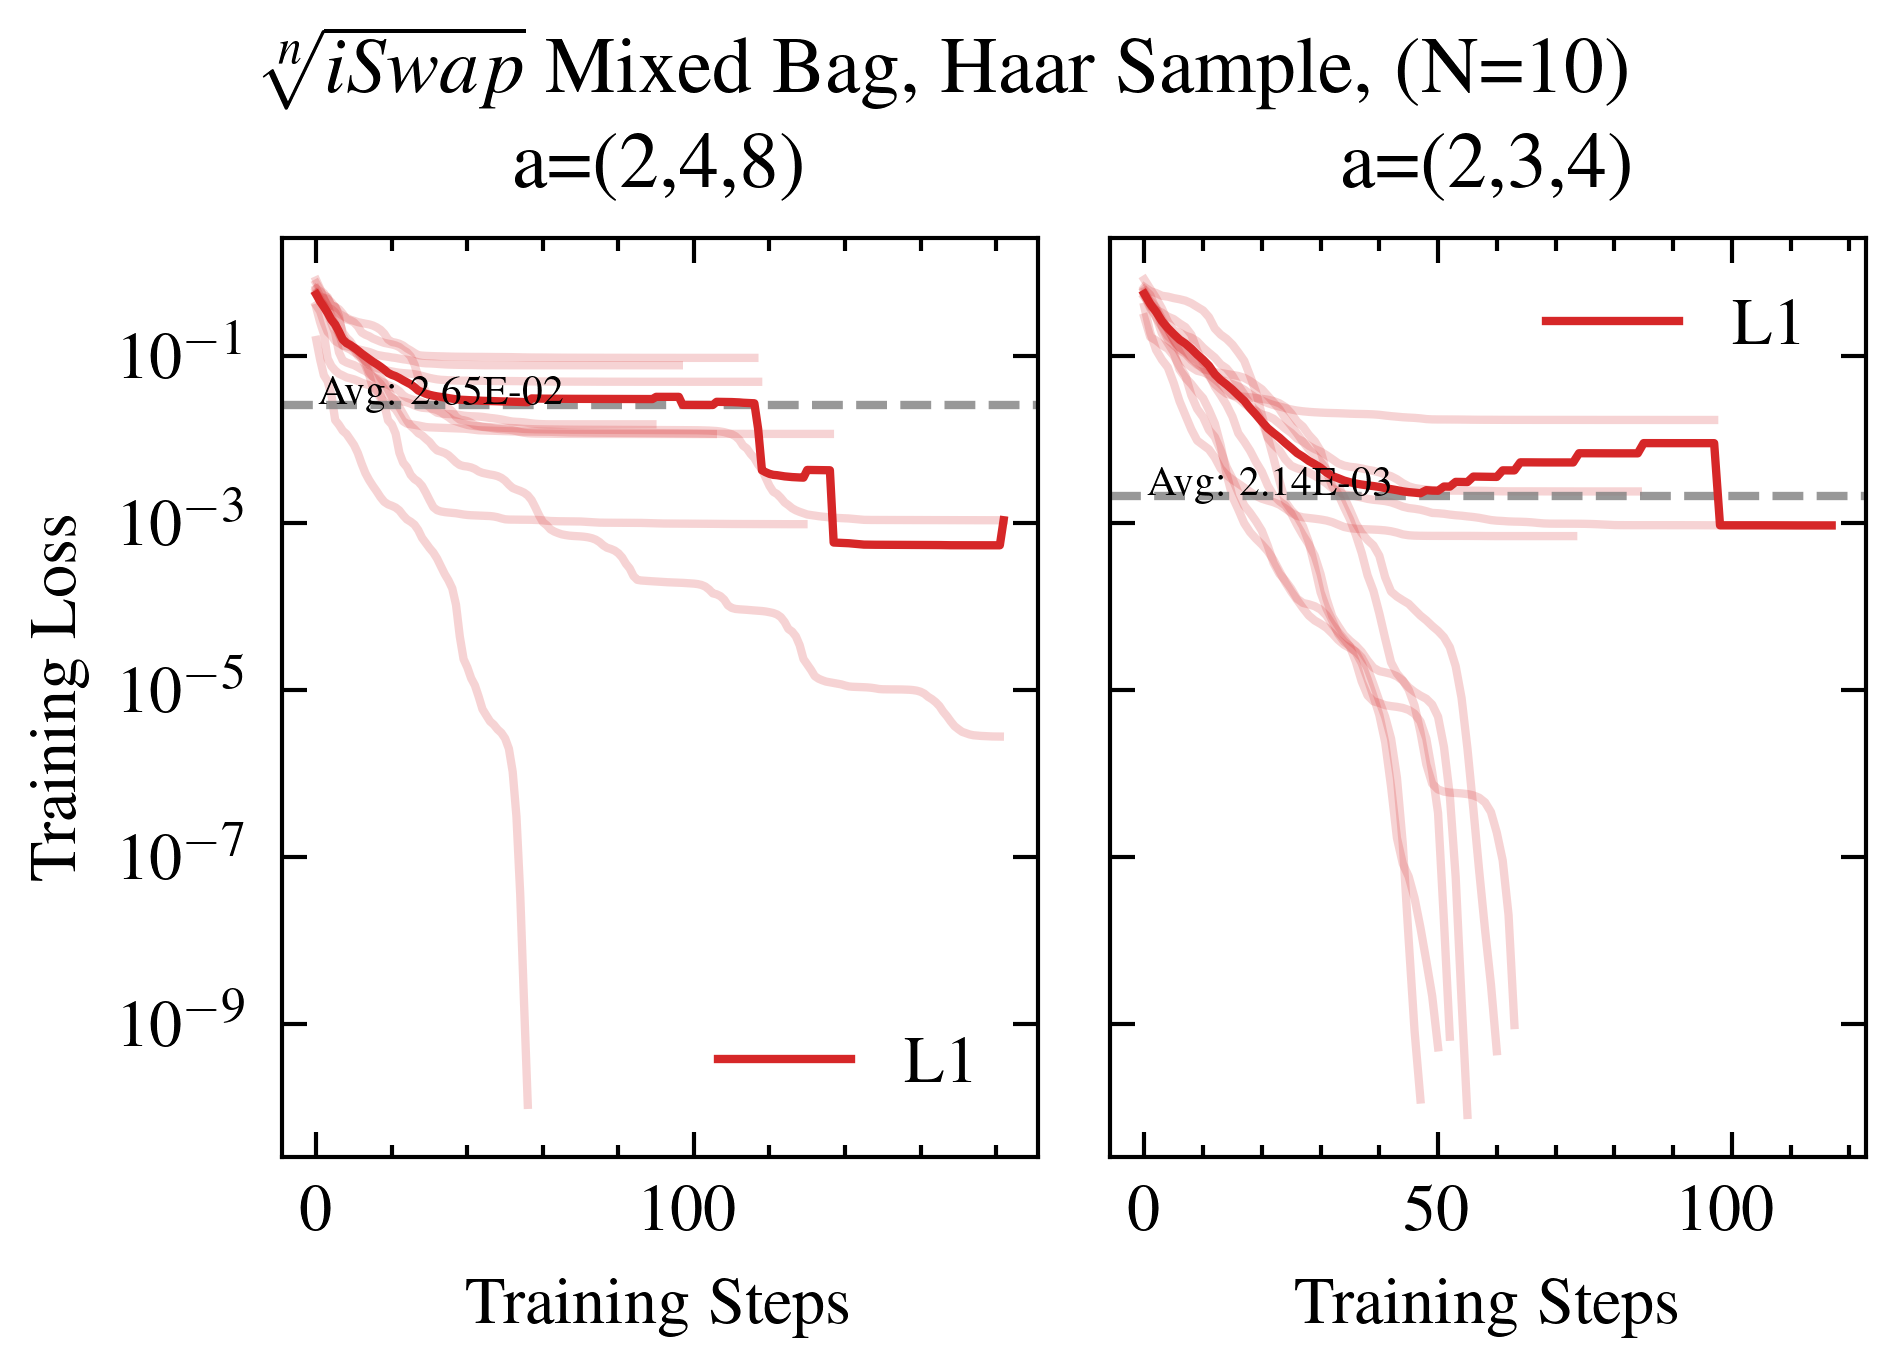

In [27]:
N = 10
template = TemplateCircuit(gate_2q_params=[1 / 2, 1 / 4, 1 / 8])
optimizer = TemplateOptimizer(template, n_samples=N, template_iter_range=range(1, 2))
optimizer.run(override_saved=False)
optimizer.plot_title = "a=(2,4,8)"

template2 = TemplateCircuit(gate_2q_params=[1 / 2, 1 / 3, 1 / 4])
optimizer2 = TemplateOptimizer(template2, n_samples=N, template_iter_range=range(1, 2))
optimizer2.run(override_saved=False)
optimizer2.plot_title = "a=(2,3,4)"

TemplateOptimizer.plot(f"{RiSwapGate.latex_string()} Mixed Bag, Haar Sample", optimizer, optimizer2)


Next, to start experimenting with larger qubit unitaries, I will build a 3Q unitary, and see if topology-dependent structures of edges make a difference. Of course, the all-to-all template is supposedely at an advantage since its since cycle template contains an extra 2Q gate. Because this takes a while I limited it to a single template cycle, but clearly this is not enough for the 3Q gates since these on't converge to a small loss value.

INFO:root:Loaded 5 samples
INFO:root:Loaded 5 samples
INFO:root:Loaded 5 samples


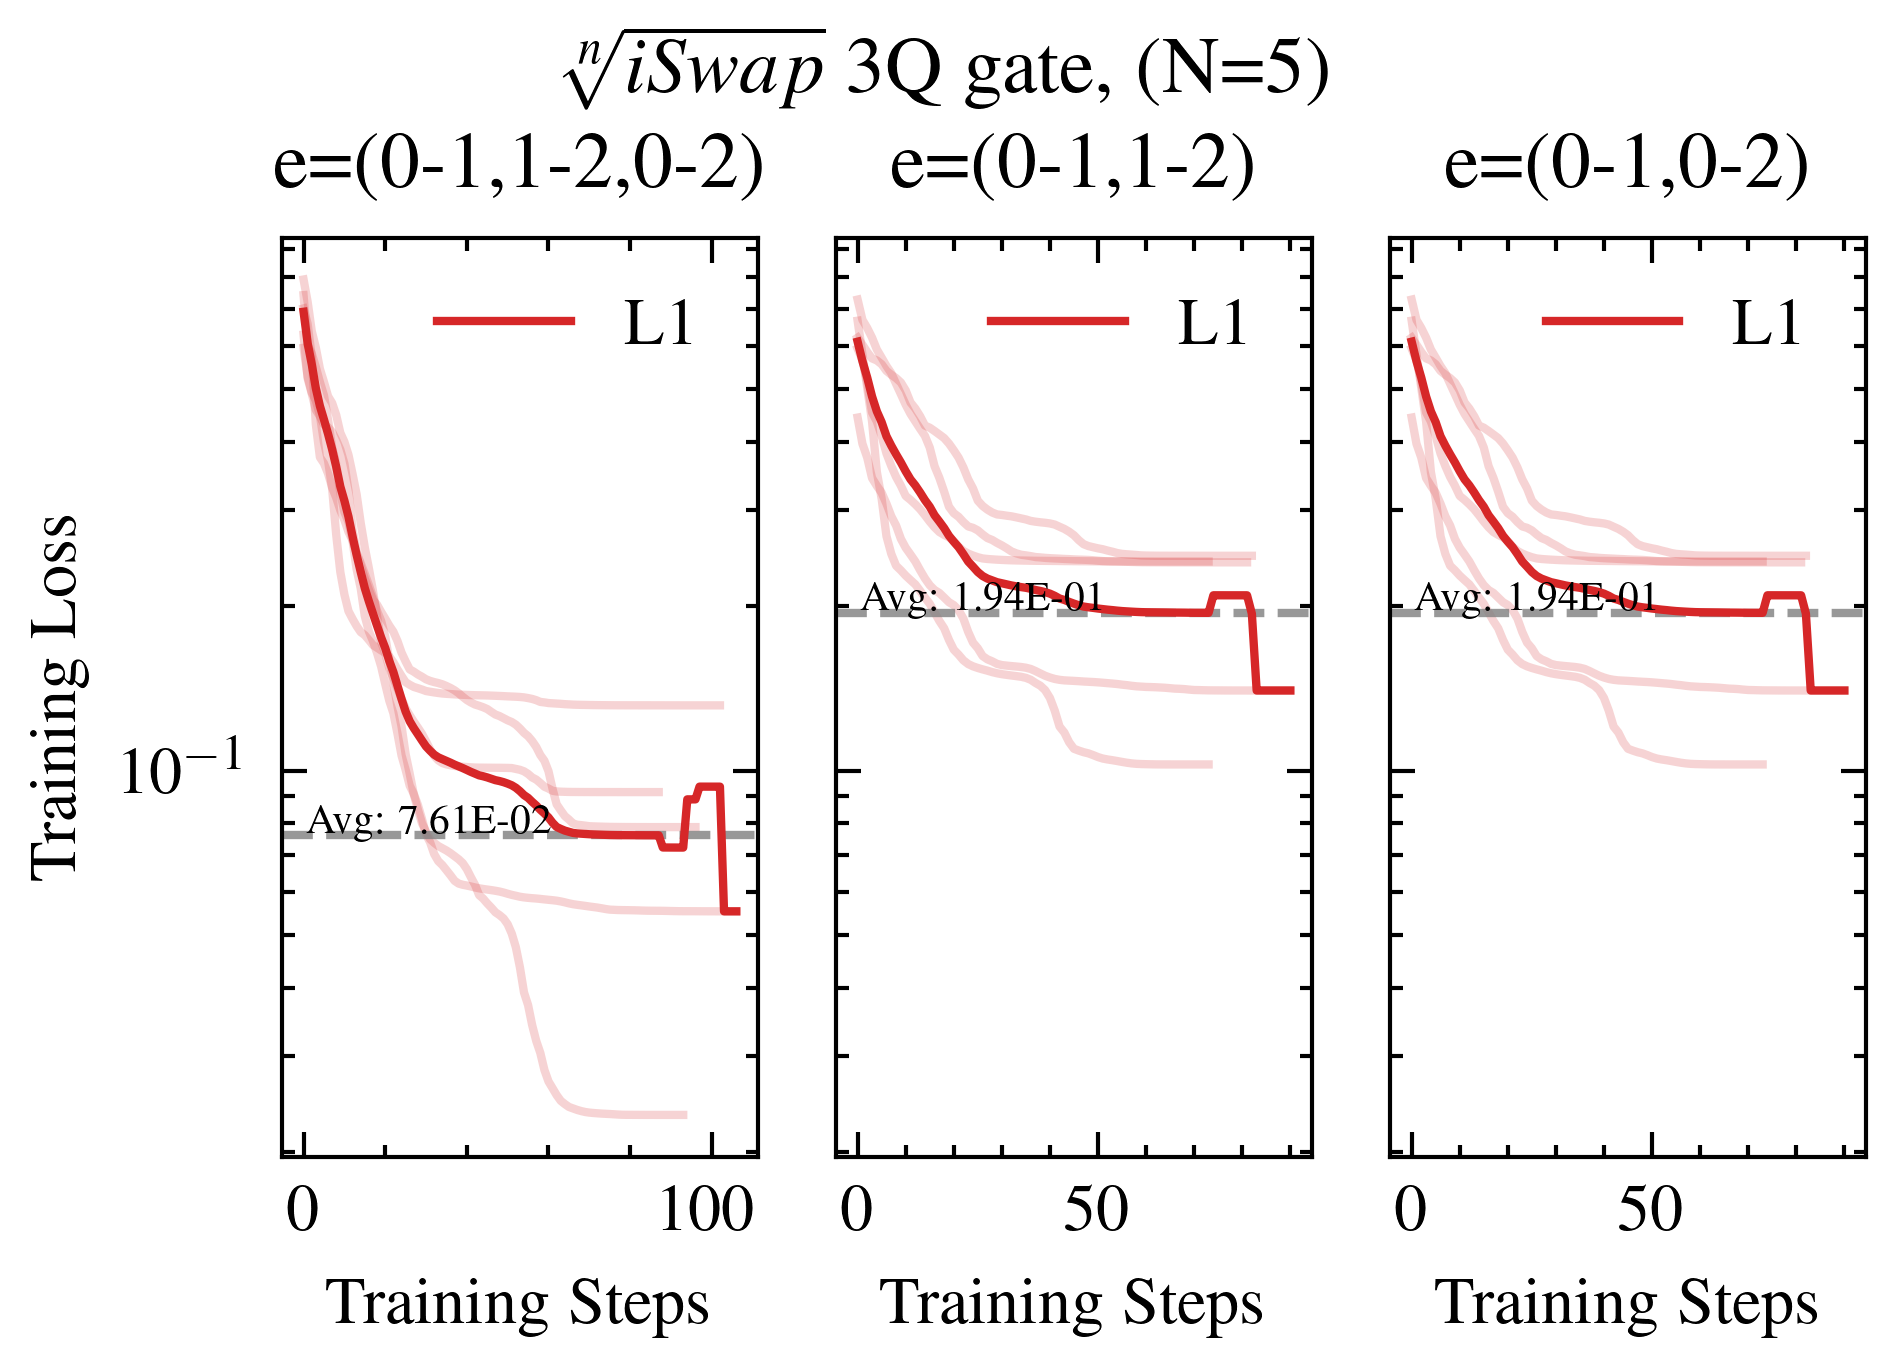

In [28]:
N = 5
template = TemplateCircuit(n_qubits=3, edge_params=[(0,1), (1,2), (0,2)])
optimizer = TemplateOptimizer(template, n_samples=N, template_iter_range=range(1, 2))
optimizer.run(override_saved=False)
optimizer.plot_title = "e=(0-1,1-2,0-2)"

template2 = TemplateCircuit(n_qubits=3, edge_params=[(0,1), (1,2)])
optimizer2 = TemplateOptimizer(template2, n_samples=N, template_iter_range=range(1, 2))
optimizer2.run(override_saved=False)
optimizer2.plot_title = "e=(0-1,1-2)"

template3 = TemplateCircuit(n_qubits=3, edge_params=[(0,1), (0,2)])
optimizer3 = TemplateOptimizer(template2, n_samples=N, template_iter_range=range(1, 2))
optimizer3.run(override_saved=False)
optimizer3.plot_title = "e=(0-1,0-2)"

TemplateOptimizer.plot(f"{RiSwapGate.latex_string()} 3Q gate", optimizer, optimizer2, optimizer3)


Next, try using Weyl chamber coordinates as a different distance metric. I know that this is not currently well optmiized but just want to see if there is any merit to expanding this idea just to try something I had seen before.

In [ ]:
N = 5
template = TemplateCircuit()
optimizer = TemplateOptimizer(template, n_samples=N, objective_function_name="nuop")
optimizer.run(override_saved=True)
optimizer.plot_title = "Basic"

optimizer2 = TemplateOptimizer(template, n_samples=N, objective_function_name="weyl")
optimizer2.run(override_saved=True)
optimizer2.plot_title = "Weyl"
TemplateOptimizer.plot(f"{RiSwapGate.latex_string(2)} var objectives, Haar sample", optimizer, optimizer2)


INFO:root:Starting sample iter 0
INFO:root:loss= 2.047596536769447e-10
INFO:root:Starting sample iter 1
INFO:root:loss= 1.5124901331375895e-10
INFO:root:Starting sample iter 2
INFO:root:loss= 8.662504047407538e-11
INFO:root:Starting sample iter 3
INFO:root:loss= 6.146098074921724e-10
INFO:root:Starting sample iter 4
INFO:root:loss= 7.168231563881022e-10
INFO:root:Starting sample iter 0
INFO:root:loss= 0.09142493446066287
INFO:root:Starting sample iter 1
INFO:root:loss= 0.07074610932085597
INFO:root:Starting sample iter 2
INFO:root:loss= 0.018953005925710035
INFO:root:Starting sample iter 3
INFO:root:loss= 0.20356526768111746
INFO:root:Starting sample iter 4
INFO:root:loss= 0.19771796981802617


ValueError: cant extend blank row